In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
#                    a=NH3    b=O2   c=NO   d=H2O  e=N2   f=NO2
Rxn_coef = np.array([
                    [ -4.0,  -5.0,   4.0,   6.0,   0.0,   0.0], # rxn (1a)
                    [ -2.0,  -1.5,   0.0,   3.0,   1.0,   0.0], # rxn (2a)
                    [  0.0,  -1.0,  -2.0,   0.0,   0.0,   2.0], # rxn (3b)
                    [ -4.0,   0.0,  -6.0,   6.0,   5.0,   0.0]  # rxn (4c)
                                                             ])

In [3]:
df = pd.DataFrame(Rxn_coef)
df.columns = ['a', 'b', 'c', 'd', 'e', 'f']
df.index = ['1a', '2a', '3b', '4c']
df

,a,b,c,d,e,f
1a,-4.0,-5.0,4.0,6.0,0.0,0.0
2a,-2.0,-1.5,0.0,3.0,1.0,0.0
3b,0.0,-1.0,-2.0,0.0,0.0,2.0
4c,-4.0,0.0,-6.0,6.0,5.0,0.0


In [4]:
df_T = df.transpose()
df_T

,1a,2a,3b,4c
a,-4.0,-2.0,0.0,-4.0
b,-5.0,-1.5,-1.0,0.0
c,4.0,0.0,-2.0,-6.0
d,6.0,3.0,0.0,6.0
e,0.0,1.0,0.0,5.0
f,0.0,0.0,2.0,0.0


In [5]:
lst = [df_T.loc['a', '1a'], df_T.loc['a', '2a'], df_T.loc['b', '3b'], df_T.loc['c', '4c']]
lst

[-4.0, -2.0, -1.0, -6.0]

In [6]:
# df.div | df.mul
newdf = df.div(lst, axis=0)
newdf

,a,b,c,d,e,f
1a,1.000000,1.25,-1.0,-1.5,-0.000000,-0.0
2a,1.000000,0.75,-0.0,-1.5,-0.500000,-0.0
3b,-0.000000,1.00,2.0,-0.0,-0.000000,-2.0
4c,0.666667,-0.00,1.0,-1.0,-0.833333,-0.0


In [7]:
rate_coef = np.array(newdf.transpose())
rate_coef

array([[ 1.        ,  1.        , -0.        ,  0.66666667],
       [ 1.25      ,  0.75      ,  1.        , -0.        ],
       [-1.        , -0.        ,  2.        ,  1.        ],
       [-1.5       , -1.5       , -0.        , -1.        ],
       [-0.        , -0.5       , -0.        , -0.83333333],
       [-0.        , -0.        , -2.        , -0.        ]])

In [8]:
vol_flow = 10 # L/min
V = 10 # L
Ca0 = 1.0; Cb0 = 1.0 # mol/L
Ct0 = Ca0 + Cb0 # mol/L initial total concentration
Fa0 = vol_flow*Ca0 # mol/min
Fb0 = vol_flow*Cb0 # L/min
Fc0 = 0; Fd0 = 0; Fe0 = 0; Ff0 = 0 # L/min
Ft0 = Fa0 + Fb0 + Fc0 + Fd0 + Fe0 + Ff0 # L/min

k1a = 5.0 # ((m^3/kmol)^2)/min
k2a = 2.0 # (m^3/kmol/min)
k3b = 10.0 # ((m^3/kmol)^2)/min
k4c = 5.0 # ((m^3/kmol)^2/3)/min

In [9]:
def func(C, V):
    Ca, Cb, Cc, Cd, Ce, Cf = C
    
    r1a = -k1a*Ca*Cb**2 # be careful of the minus sign
    r2a = -k2a*Ca*Cb
    r3b = -k3b*Cb*Cc**2
    r4c = -k4c*Cc*Ca**(2/3)
    
    rds = np.array([r1a, r2a, r3b, r4c])
    total_rxn = rate_coef*rds
    
    ra = sum(total_rxn[0])
    rb = sum(total_rxn[1])
    rc = sum(total_rxn[2])
    rd = sum(total_rxn[3])
    re = sum(total_rxn[4])
    rf = sum(total_rxn[5])
    
    dCadV = ra/vol_flow
    dCbdV = rb/vol_flow
    dCcdV = rc/vol_flow
    dCddV = rd/vol_flow
    dCedV = re/vol_flow
    dCfdV = rf/vol_flow
    
    return [dCadV, dCbdV, dCcdV, dCddV, dCedV, dCfdV]
    
# initial conditions for the dependent variables
x0 = [Ca0, Cb0, 0, 0, 0, 0]

# declare a volume vector (volume window) for independent variable
Vspan = np.linspace(0, V)
# call the function
sol = odeint(func, x0, Vspan)

Ca, Cb, Cc, Cd, Ce, Cf = sol.T

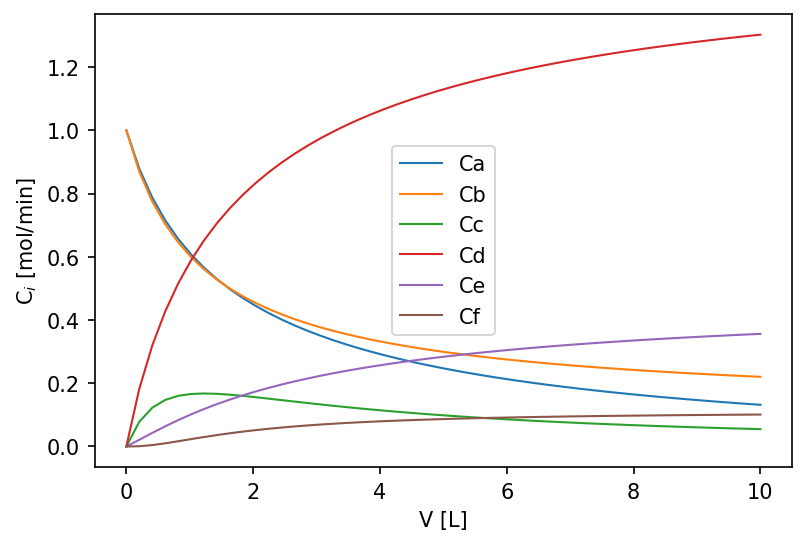

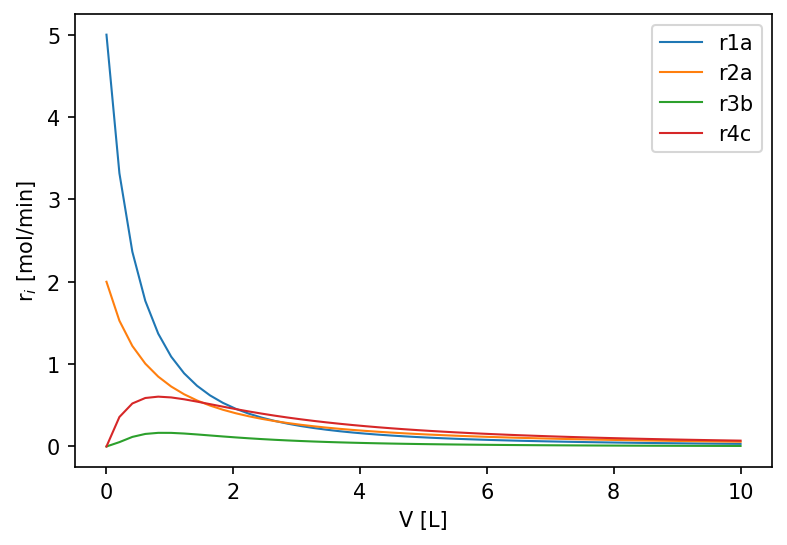

In [10]:
molar_lst = []
for conc in sol.T:
    molar_lst.append(conc/Ct0)
        
r1a = k1a*Ca*Cb**2
r2a = k2a*Ca*Cb
r3b = k3b*Cb*Cc**2
r4c = k4c*Cc*Ca**(2/3)

rds = np.array([r1a, r2a, r3b, r4c])

plt.figure(dpi=150)
plt.plot(Vspan, Ca, label = 'Ca', lw = 1)
plt.plot(Vspan, Cb, label = 'Cb', lw = 1)
plt.plot(Vspan, Cc, label = 'Cc', lw = 1)
plt.plot(Vspan, Cd, label = 'Cd', lw = 1)
plt.plot(Vspan, Ce, label = 'Ce', lw = 1)
plt.plot(Vspan, Cf, label = 'Cf', lw = 1)

plt.ylabel('C$_i$ [mol/min]')
plt.xlabel('V [L]')
plt.legend(loc='best')

plt.figure(dpi=150)
plt.plot(Vspan, r1a, label = 'r1a', lw = 1)
plt.plot(Vspan, r2a, label = 'r2a', lw = 1)
plt.plot(Vspan, r3b, label = 'r3b', lw = 1)
plt.plot(Vspan, r4c, label = 'r4c', lw = 1)

plt.ylabel('r$_i$ [mol/min]')
plt.xlabel('V [L]')
plt.legend(loc='best')